# Supervised Learning Project
***
In this project we will be building a machine learning model to assist Beta Bank predict which of its customers might leave the insitution. In order to do that we will import info supplied by Beta Bank about customers who both have and have not left the bank for us to train and test models in order to make the best predictions possible.

We will test the F1 Score and the final test will have a minimum standard score of 0.59. Once the final model has passed the test, it's Receiver Operating Characteristic(ROC) Curve will be drawn and the AUC ROC metric will be calculated to ensure the accuracy of the model.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

## Loading Data

Reading the data into a pandas DataFrame from `/datasets/Churn.csv`.

Then displaying basic info and a sample of the dataset.

In [2]:
# Loading data
data = pd.read_csv('Churn.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


The table has 10000 rows and 15 columns that contain all the feature and target data that will be used to train, validate and test the model.

**Feature Data:**
- `RowNumber` — data string index
- `CustomerId` — unique customer identifier
- `Surname` — customer's surname
- `CreditScore` — credit score
- `Geography` — country of residence (`Spain`, `France`, `Germany`) 
- `Gender` — gender (`Male`, `Female`)
- `Age` — age 
- `Tenure` — period of maturation for a customer’s fixed deposit (years)
- `Balance` — account balance
- `NumOfProducts` — number of banking products used by the customer
- `HasCrCard` — customer has a credit card (Boolean)
- `IsActiveMember` — customer’s activeness (Boolean)
- `EstimatedSalary` — estimated salary

**Target Data:**
- `Exited` — сustomer has left (Boolean)

Columns will be edited for readability.

In [3]:
# Editing columns
data.columns = ['row_number',
                'customer_id',
                'surname',
                'credit_score',
                'geography',
                'gender',
                'age',
                'tenure',
                'balance',
                'num_of_products',
                'has_cr_card',
                'is_active_member',
                'estimated_salary',
                'exited']
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## Missing Values

The models cannot handle NaN values so missing values in the `tenure` column will be filled in with the median value for the column.

In [4]:
# Checking missing values
display(data['tenure'].isna().sum())

# Filling missing values
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data['tenure'].value_counts(dropna=False)

909

tenure
5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: count, dtype: int64

## Duplicated Values

Checking for duplicate values in the whole dataset and the `customer_id` column to ensure accuracy of the dataset.

In [5]:
# Checking for duplicate values
display(data.duplicated().sum())
data['customer_id'].duplicated().sum()

0

0

## Preparing Data for Models

The models cannot read string data so One-Hot Encoding will be used for the `Gender` column setting the `drop_first` argument to True to avoid the dummy trap. 

In [6]:
# Applying OHE to the gender column
data = pd.get_dummies(data, columns=['gender'], drop_first=True)
data.head()

,row_number,customer_id,surname,credit_score,geography,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male
0,1,15634602,Hargrave,619,France,42,2.0,0.00,1,1,1,101348.88,1,False
1,2,15647311,Hill,608,Spain,41,1.0,83807.86,1,0,1,112542.58,0,False
2,3,15619304,Onio,502,France,42,8.0,159660.80,3,1,0,113931.57,1,False
3,4,15701354,Boni,699,France,39,1.0,0.00,2,0,0,93826.63,0,False
4,5,15737888,Mitchell,850,Spain,43,2.0,125510.82,1,1,1,79084.10,0,False


Label Encoding will be used for the `surname` and `geography` columns as they have more than 2 entries. 

In [7]:
# Encoding the remaining str values
data_to_encode = data[['surname', 'geography']]
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_to_encode), columns=data_to_encode.columns)
data['surname'] = data_ordinal['surname']
data['geography'] = data_ordinal['geography']
data.info()
display()

# Examining class balance
for column in data:
    print(column, f'Max Value: {data[column].max()}', f'Min Value: {data[column].min()}', '', sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  float64
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  float64
 5   age               10000 non-null  int64  
 6   tenure            10000 non-null  float64
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
 13  gender_Male       10000 non-null  bool   
dtypes: bool(1), float64(5), int64(8)
memory usage: 1.0 MB
row_number
Max Value: 10000
Min Value: 1

customer_id
Max Value: 15815690
Min Val

All columns have been converted into **int** or **float** datatypes.

Classes are very unbalanced. 

`estimated_salary` ranges from `199992.48 - 11.58` and `balance` ranges from `250898.09 - 0.0` while 3 features are boolean and others have between `3 - 10` total values.

The models will first be trained without considering weights.

The data will now be split into Training, Validation, and Final Test datasets at a ratio of 3:1:1.

In [8]:
train, valid_test = train_test_split(data, test_size=0.4, random_state=45678)
valid, test = train_test_split(valid_test, test_size=0.5, random_state=45678)

print('Training dataset ratio:', len(train)/len(data))
print('Validation dataset ratio:', len(valid)/len(data))
print('Test dataset ratio:', len(test)/len(data))

Training dataset ratio: 0.6
Validation dataset ratio: 0.2
Test dataset ratio: 0.2


Now the datasets will be split further into feature and target data for training purposes.

In [9]:
feature_train = train.drop('exited', axis=1)
target_train = train['exited']
feature_valid = valid.drop('exited', axis=1)
target_valid = valid['exited']
feature_test = test.drop('exited', axis=1)
target_test = test['exited']
print(feature_train.shape, target_train.shape)
print(feature_valid.shape, target_valid.shape)
feature_test.shape, target_test.shape

(6000, 13) (6000,)
(2000, 13) (2000,)


((2000, 13), (2000,))

## Training Models

We will train 3 separate machine learning models to determine the best for our purposes:

1. `DecisionTreeClassifier`
2. `RandomForestClassifier`
3. `LogisticRegression` 

In [10]:
# Evaluating DecisionTreeClassifier
best_depth = 0
best_result = 0
for depth in range(1, 11):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(feature_train, target_train)
    tree_valid = tree.predict(feature_valid)
    result = f1_score(target_valid, tree_valid)
    if result > best_result:
        tree_depth = depth
        best_result = result
        best_tree = tree
display(f'Best Depth: {tree_depth} F1 Score: {best_result:.3f}')

'Best Depth: 5 F1 Score: 0.552'

The best Decision Tree model had a depth of 5 and an F1 Score of 0.552. 

In [11]:
# Evaluating RandomForestClassifier
best_score = 0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1,16):
        forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        forest.fit(feature_train, target_train)
        forest_pred = forest.predict(feature_valid)
        score = f1_score(target_valid, forest_pred)
        if score > best_score:
            best_score = score 
            best_forest = forest
            forest_depth = depth
            best_est = est
display(f'Best Number of Estimators: {best_est} Best Depth: {forest_depth} F1 score: {best_score:.3f}')

'Best Number of Estimators: 100 Best Depth: 14 F1 score: 0.572'

The best Random Forest model had 100 estimators and a depth of 14 with an F1 Score of 0.572.

In [12]:
# Evaluating LogisticRegression
log = LogisticRegression(random_state=12345, solver='liblinear')
log.fit(feature_train, target_train)

probabilities_valid = log.predict_proba(feature_valid)
probabilities_train = log.predict_proba(feature_train)
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_one_train = probabilities_train[:, 1]

best_f1 = 0
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    predicted_train = probabilities_one_train > threshold
    f1_valid = f1_score(target_valid, predicted_valid)
    f1_train = f1_score(target_train, predicted_train)
    if f1_valid > best_f1:
        best_f1 = f1_valid
        best_threshold = threshold
        train_f1 = f1_train
display(f'Threshold = {best_threshold} | F1 Score = {best_f1:.3f}, F1 Train = {train_f1:.3f}')

'Threshold = 0.22 | F1 Score = 0.354, F1 Train = 0.364'

The best threshold for the Logistic Regression model was 0.22 with an F1 Score for the validation dataset of 0.354, and an F1 score of 0.364 with the training dataset.

Due to the imbalance of the classes the models did not preform very well at all, none of them even approacing the target F1 Score of 0.59.

## Class Balance

In order to first achieve a more optimal F1 score with the validation dataset, we will take the training dataset and upsample the data of users who have exited the insitution. 

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(
    feature_train, target_train, 7
)

features_upsampled.shape, target_upsampled.shape

((13650, 13), (13650,))

## Retraining Models

        
With the now upsampled dataset, we will retrain all the models to determine the best model for the final test. All models will be trained with `'balanced'` passed through the `class_weight` argument for each. 

**Upsampled Dataset:**

In [14]:
# Evaluating DecisionTreeClassifier with upsampled dataset
best_depth = 0
best_result = 0
for depth in range(1, 11):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(features_upsampled, target_upsampled)
    tree_valid = tree.predict(feature_valid)
    result = f1_score(target_valid, tree_valid)
    if result > best_result:
        tree_depth = depth
        best_result = result
        best_tree = tree
display(f'Best Depth: {tree_depth} F1 Score: {best_result:.3f}')

'Best Depth: 7 F1 Score: 0.476'

The best Decision Tree model using the upsampled dataset had a depth of 5 and an F1 Score of 0.546.

In [15]:
# Evaluating DecisionTreeClassifier with class_weight = 'balanced'
best_depth = 0
best_result = 0
for depth in range(1, 11):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    tree.fit(feature_train, target_train)
    tree_valid = tree.predict(feature_valid)
    result = f1_score(target_valid, tree_valid)
    if result > best_result:
        tree_depth = depth
        best_result = result
        best_tree_balance = tree
display(f'Best Depth: {tree_depth} F1 Score: {best_result:.3f}')

'Best Depth: 5 F1 Score: 0.520'

The best Decision Tree model using `class_weight = 'balanced'` had a depth of 5 and an F1 Score of 0.520.

In [16]:
# Evaluating RandomForestClassifier with upsampled dataset
best_score = 0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1,16):
        forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        forest.fit(features_upsampled, target_upsampled)
        forest_pred = forest.predict(feature_valid)
        score = f1_score(target_valid, forest_pred)
        if score > best_score:
            best_score = score 
            best_forest = forest
            forest_depth = depth
            best_est = est
display(f'Best Number of Estimators: {best_est} Best Depth: {forest_depth} F1 score: {best_score:.3f}')

'Best Number of Estimators: 40 Best Depth: 15 F1 score: 0.586'

The best Random Forest model had 40 estimators and a depth of 15 with an F1 Score of 0.586.

In [17]:
# Evaluating RandomForestClassifier with class_weight = 'balanced'
best_score = 0
best_est = 0
for est in range(10, 101, 10):
    for depth in range(1,16):
        forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') 
        forest.fit(feature_train, target_train)
        forest_pred = forest.predict(feature_valid)
        score = f1_score(target_valid, forest_pred)
        if score > best_score:
            best_score = score 
            best_forest_balance = forest
            forest_depth = depth
            best_est = est
display(f'Best Number of Estimators: {best_est} Best Depth: {forest_depth} F1 score: {best_score:.3f}')

'Best Number of Estimators: 20 Best Depth: 11 F1 score: 0.590'

The best Random Forest model had 20 estimators and a depth of 11 with an F1 Score of 0.599, which meets the goal F1 score of 0.59.

In [18]:
# Evaluating LogisticRegression with upsampled dataset
log = LogisticRegression(random_state=12345, solver='liblinear')
log.fit(features_upsampled, target_upsampled)

probabilities_valid = log.predict_proba(feature_valid)
probabilities_upscale = log.predict_proba(features_upsampled)
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_one_upscale = probabilities_upscale[:, 1]

best_f1 = 0
best_threshold = 0
best_upsample = 0
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    predicted_upscale = probabilities_one_upscale > threshold
    f1_valid = f1_score(target_valid, predicted_valid)
    f1_train = f1_score(target_train, predicted_train)
    f1_upsample = f1_score(target_upsampled, predicted_upscale)
    if f1_valid > best_f1:
        best_f1 = f1_valid
        best_threshold = threshold
        best_upsample = f1_upsample
        train_f1 = f1_train
display(f'Threshold = {best_threshold} | F1 Score = {best_f1:.3f}, F1 Train = {train_f1:.3f}, F1 Upsample = {best_upsample:.3f}')

'Threshold = 0.0 | F1 Score = 0.324, F1 Train = 0.097, F1 Upsample = 0.791'

The best threshold for the Logistic Regression model using upsampled data was 0.0 with an F1 Score for the validation dataset of 0.324. The model preformed exeedingly well with the upsampled training set at an F1 Score of 0.730, but preformed very poorly with the original training dataset.

In [19]:
# Evaluating LogisticRegression with class_weight = 'balanced'
log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
log.fit(feature_train, target_train)

probabilities_valid = log.predict_proba(feature_valid)
probabilities_train = log.predict_proba(feature_train)
probabilities_one_valid = probabilities_valid[:, 1]
probabilities_one_train = probabilities_train[:, 1]

best_f1 = 0
best_threshold = 0
best_upsample = 0
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    predicted_train = probabilities_one_train > threshold
    f1_valid = f1_score(target_valid, predicted_valid)
    f1_train = f1_score(target_train, predicted_train)
    if f1_valid > best_f1:
        best_f1 = f1_valid
        best_threshold = threshold
        train_f1 = f1_train
display(f'Threshold = {best_threshold} | F1 Score = {best_f1:.3f}, F1 Train = {train_f1:.3f}')

'Threshold = 0.28 | F1 Score = 0.360, F1 Train = 0.385'

The best threshold for the Logistic Regression model was 0.28 with an F1 Score for the validation dataset of 0.382. The model preformed better with the training set at an F1 Score of 0.416. 

## Final Test

The best model was by far the Random Forest, so the forest with the best score on the validation set will be used in the final test.

In [20]:
test_predictions = best_forest_balance.predict(feature_test)
test_score = f1_score(target_test, test_predictions)
f'Best model F1 Score with test dataset: {test_score:.3f}'

'Best model F1 Score with test dataset: 0.588'

The model recieved an F1 Score of 0.578. 

## AUC ROC

We will now calculate the Receiver Operating Characteristic of the best model with the test dataset in order to evaluate the Area Under Curve metric against the F1 Score the model recieved.

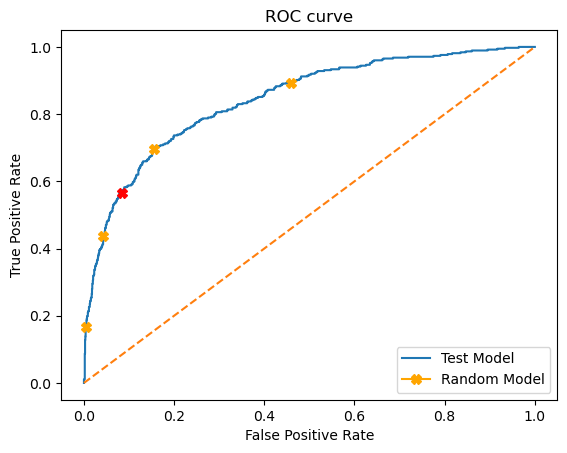

In [24]:
probabilities_test = best_forest_balance.predict_proba(feature_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()

plt.plot(fpr, tpr)
for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            plt.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test Model', 'Random Model'], loc='lower right')
plt.title('ROC curve')
plt.show()

The best model trained performed remarkably better than a random model. Now to calculate the AUC ROC:

In [22]:
auc_roc = roc_auc_score(target_test, probabilities_one_test)
auc_roc

0.8430916570590085

The best model's AUC ROC was a whopping 0.843. With this in mind and the models test F1 Score, Beta Bank can be assured that the model will predict potential exits with extreme standards.